<a href="https://colab.research.google.com/github/Rafi076/RTFER_Framework/blob/main/RTFER_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!git clone https://github.com/Rafi076/RTFER_Framework.git

fatal: destination path 'RTFER_Framework' already exists and is not an empty directory.


In [15]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# STEP 2: Correct zip path (case-sensitive, and spelling checked)
zip_path = '/content/drive/MyDrive/RTFER_Framwork/FER-2013.zip'
extract_to = '/content'  # Since zip already has a folder inside, extract to /content

# STEP 3: Unzip
import zipfile, os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped successfully!")


✅ Unzipped successfully!


In [17]:
# Show contents of the extracted folder
!ls "/content/FER-2013"

test  train


**Step 3: Import Libraries**

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix


**Step 4: Define Transforms for Data Augmentation**

In [19]:


# ✅ Final Step 4:
train_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # for 3 channels
])

test_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # for 3 channels
])


**Step 5: Load the Dataset**

We load images using ImageFolder.

In [20]:
from torch.utils.data import Subset, DataLoader
import numpy as np

train_dir = "/content/FER-2013/train"
test_dir = "/content/FER-2013/test"

# Apply transforms
train_data_full = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# ✅ Reduce training dataset size (use 8000 samples for faster training)
subset_size = 8000  # You can try 5000 for even faster training
train_subset_indices = list(range(subset_size))
train_data = Subset(train_data_full, train_subset_indices)

# ✅ Class names (from full set, safe to use)
class_names = train_data_full.classes
print("Classes:", class_names)

# ✅ Split into train and val
val_percent = 0.1  # 10% for validation
num_val = int(len(train_data) * val_percent)
indices = np.random.permutation(len(train_data))

val_indices = indices[:num_val]
train_indices = indices[num_val:]

train_subset = Subset(train_data, train_indices)
val_subset = Subset(train_data, val_indices)

# ✅ Use larger batch size for speed (if memory allows)
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


**Step 6: Visualize Sample Images**

Before training, let’s confirm that the images and labels are loading correctly:

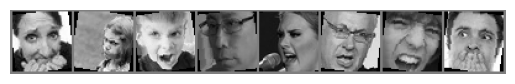

fear angry angry angry angry angry angry fear


In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Helper function to show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Show labels
print(' '.join(f'{class_names[labels[j]]}' for j in range(8)))


**Step 7: Build the CNN Model**

We’ll start with a simple custom CNN model. Later, we can improve it or use pretrained models like ResNet.

In [22]:
from torchvision import models
import torch.nn as nn

class ResNetFER(nn.Module):
    def __init__(self):
        super(ResNetFER, self).__init__()
        self.model = models.resnet18(pretrained=True)  # keep pretrained weights
        self.model.fc = nn.Linear(self.model.fc.in_features, 7)  # 7 emotions

    def forward(self, x):
        return self.model(x)


**Step 8: Define Loss, Optimizer, and Move Model to GPU**

In [23]:
# ✅ Step 8: Model setup, optimizer, loss, scheduler, early stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetFER().to(device)

# 🧠 Compile the model for faster training (PyTorch 2.x+)
model = torch.compile(model)

# 🔧 Enable cuDNN auto-tuner (only for GPU; speeds up conv layers)
torch.backends.cudnn.benchmark = True

# 🔒 Freeze all pretrained layers
for param in model.model.parameters():
    param.requires_grad = False

# 🔓 Unfreeze last ResNet block and final FC layer for fine-tuning
for param in model.model.layer4.parameters():
    param.requires_grad = True
for param in model.model.fc.parameters():
    param.requires_grad = True

# ✅ Optimizer (only for trainable parameters)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, weight_decay=1e-4
)

# ✅ Loss function
criterion = nn.CrossEntropyLoss()

# ✅ Learning rate scheduler (plateau-based LR reduction)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

# ✅ Early stopping setup
best_val_acc = 0.0
patience = 4
patience_counter = 0
best_model_state = None


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Step 9: Train the Model**

Let’s train for 10 epochs and monitor loss and accuracy.

In [24]:
from tqdm import tqdm

epochs = 8
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # === VALIDATION ===
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === EARLY STOPPING ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🔥 Early stopping triggered at epoch {epoch+1}")
            break

# Restore the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model restored with val accuracy: {best_val_acc:.2f}%")


Epoch 1/8: 100%|██████████| 57/57 [04:48<00:00,  5.07s/it]


Epoch 1, Train Loss: 78.1042, Train Acc: 47.79%, Val Loss: 6.5942, Val Acc: 55.88%


Epoch 2/8: 100%|██████████| 57/57 [01:49<00:00,  1.92s/it]


Epoch 2, Train Loss: 48.2747, Train Acc: 60.74%, Val Loss: 5.9705, Val Acc: 57.25%


Epoch 3/8: 100%|██████████| 57/57 [01:49<00:00,  1.93s/it]


Epoch 3, Train Loss: 43.2836, Train Acc: 65.11%, Val Loss: 5.7950, Val Acc: 60.88%


Epoch 4/8: 100%|██████████| 57/57 [01:54<00:00,  2.02s/it]


Epoch 4, Train Loss: 40.2620, Train Acc: 67.43%, Val Loss: 5.5749, Val Acc: 59.88%


Epoch 5/8: 100%|██████████| 57/57 [01:45<00:00,  1.85s/it]


Epoch 5, Train Loss: 37.7390, Train Acc: 69.65%, Val Loss: 5.6919, Val Acc: 59.75%


Epoch 6/8: 100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


Epoch 6, Train Loss: 35.2137, Train Acc: 72.24%, Val Loss: 5.3917, Val Acc: 64.38%


Epoch 7/8: 100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


Epoch 7, Train Loss: 32.7003, Train Acc: 74.61%, Val Loss: 5.6662, Val Acc: 62.25%


Epoch 8/8: 100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


Epoch 8, Train Loss: 31.6217, Train Acc: 75.92%, Val Loss: 5.4052, Val Acc: 61.25%
✅ Best model restored with val accuracy: 64.38%
